### Machine Learning

- Maria Zazpe Quintana

- Alba Rodríguez Berenguel

En este notebook vamos a realizar un modelo Decision Tree. Los pasos que vamos a seguir son:

1. Importación de librerías, funciones y datos.
2. Creación del modelo.
3. Entrenamiento del modelo.
4. Predicciones y evaluación.
5. Exportación del modelo.

## 1. Importación de librerías, funciones y datos.

In [1]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, fbeta_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report
import scikitplot as skplt
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import PartialDependenceDisplay
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function to evaluate the model
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))

In [3]:
# Load data
X_train_val = pd.read_csv("../data/processed/X_train_val.csv",index_col=0 )
y_train_val = pd.read_csv("../data/processed/y_train_val.csv",index_col=0 )

x_val = pd.read_csv("../data/processed/X_val.csv",index_col=0 )
y_val = pd.read_csv("../data/processed/y_val.csv",index_col=0 )

## 2. Creación del modelo

In [4]:
# Import the preprocessor.
preprocessor = pickle.load(open('../models/preprocessor.pickle', 'rb'))

# Classifier.
classifier = DecisionTreeClassifier()

In [5]:
dt_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

## 3. Entrenamiento del modelo.

In [6]:
dt_model.fit(X_train_val, y_train_val)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['delivery',
                                                   'outdoor_seating',
                                                   'credit_cards',
                                                   'bike_parking',
                                                   'price_range', 'take_out',
                                                   'wifi', 'alcohol', 'caters',
                                                   'wheelchair_accessible',
                                                   'good_for_kids', 'attire',
                                                   'reservations',
                                                   'table_service',
                                                   'good_for_groups', 'tv',
                                                   'noise_level']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['useful', 'funny',
                                                   'cool'])])),
                ('classifier', DecisionTreeClassifier())])

## 4. Predicciones y evaluación.

In [7]:
# Predictions of target value for the validation set.
pred = dt_model.predict(x_val)

# Predictions of probabilities of the target value for the validation set.
pred_proba = dt_model.predict_proba(x_val)

### Precision, Recall, F1 y accuracy.

In [8]:
evaluate_model(y_val, pred, pred_proba)

ROC-AUC score of the model: 0.6305058142675759
Accuracy of the model: 0.6976469204435007

Classification report: 
              precision    recall  f1-score   support

           0       0.44      0.30      0.35     45127
           1       0.76      0.85      0.80    116406

    accuracy                           0.70    161533
   macro avg       0.60      0.57      0.58    161533
weighted avg       0.67      0.70      0.68    161533




- **Support** nos dice los datos reales que tenemos, 43264 que son 0 y 110766 que son 1.


- La **precisión** se calcula con las columna de la matriz de confusión y su precisión es 0.44 para los casos 0 y 0.76 para los casos 1. Identifica mejor los 1 que los 0.


- El **recall** se calcula con las filas de la matriz de confusión, acierta el 0.86 de los casos 1, pero solo el 0.29 de los casos 0.


- El **f1** es una medida más exacta, dado que es la combinación de las métricas anteriores. Identifica 0.80 de puntuación alta y 0.35 de puntuación baja.


- El **accuracy** se calcula con la matriz de confusión, teniendo en cuenta los aciertos y es 0.698, es decir, que el modelo predice correctamente el 69.8% de los casos.

### Matriz de confusión.

Confusion matrix, without normalization
[[13330 31797]
 [17043 99363]]
Normalized confusion matrix
[[0.29538857 0.70461143]
 [0.14640998 0.85359002]]


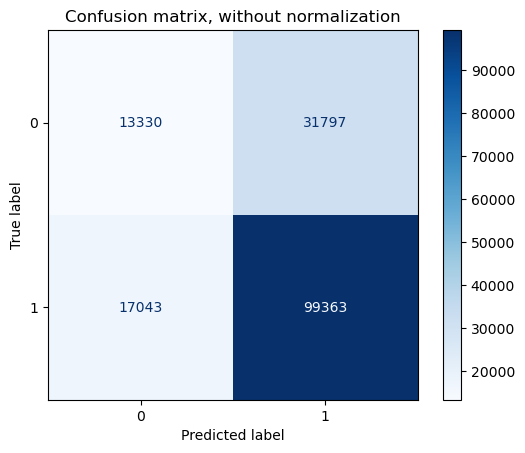

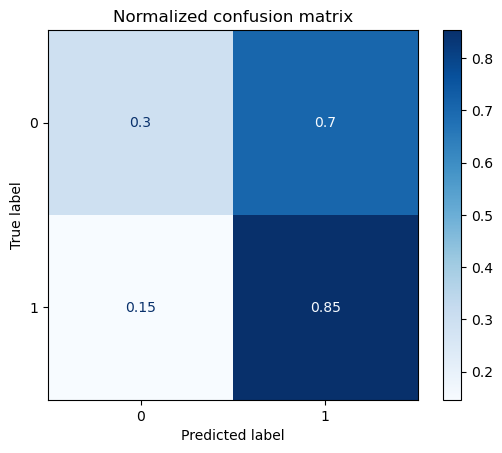

In [9]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

# Plot the confusion matrix
for title, normalize in titles_options:
    disp = plot_confusion_matrix(dt_model, x_val, y_val,
                                 # display_labels=ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

La matriz predice erroneamente el 71% de los casos 0 y el 14% de los casos 1. Por el contrario, acierta el 29% de los casos 0 y el 86% de los casos 1.

### Curva ROC.

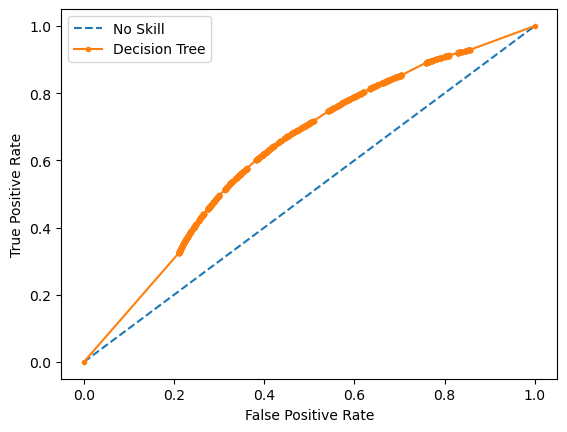

In [10]:
# Keep probabilities for the positive outcome only
yhat = pred_proba[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_val, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Decision Tree')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# Show the plot
plt.show()

La clave de la curva ROC es que cuanto más cerca esté de la esquina superior izquierda de nuestro gráfico y cuanta más área haya debajo de la curva, mejor será el modelo. En este caso se aprecia que la curva está por encima de la línea de puntos, pero esto no quiere decir que sea un buen modelo. 

### Curva Lift.

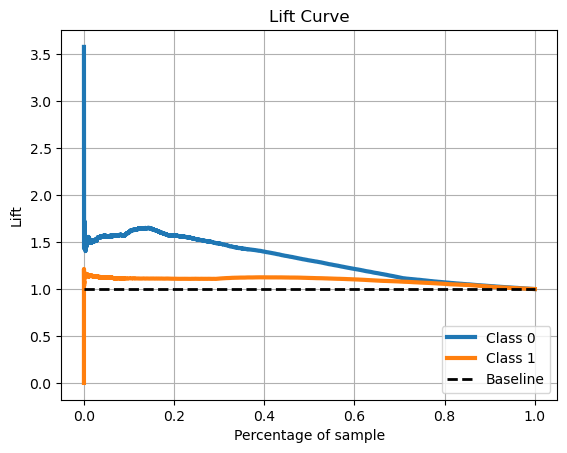

In [11]:
skplt.metrics.plot_lift_curve(y_val, pred_proba)
plt.show()

La clase 1 más o menos se mantiene constante la predicción para todos los porcentajes de muestra, siendo mejor el modelo que la aletoriedad.

### Curva de ganancia.

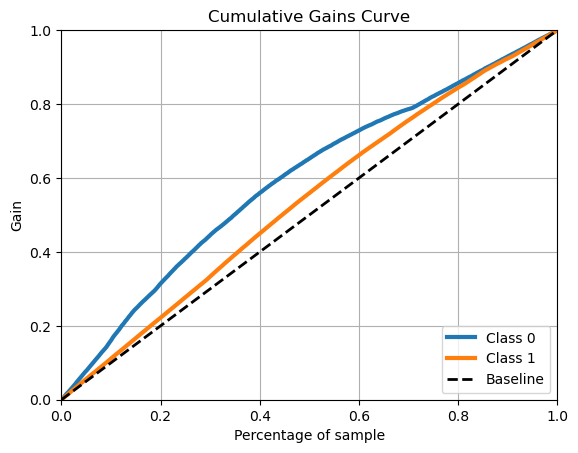

In [12]:
skplt.metrics.plot_cumulative_gain(y_val, pred_proba)
plt.show()

La ganancia de la clase 0 es superior a la de la clase 1, tomando por ejemplo el 20% de la muestra, se detectaría sobre el 20% de la clase 1 y el 40% de la clase 0. Esta probabilidad aumenta a media que se incrementa el tamaño de la muestra. La línea de la clase 1 es prácticamente recta y muy cerca de la línea de puntos, cerca de ser similar el modelo a aleatoriedad. A partir del 60% la curva de la clase 0 parecía tomar una tendencia a la baja, pero sigue creciendo.

## 5. Exportación del modelo.

In [13]:
# We save the model
with open('../models/decision_tree.pickle', 'wb') as f:
    pickle.dump(dt_model, f)

In [14]:
# To avoid the fit again.
with open('../models/decision_tree.pickle', 'rb') as f:
    dt_model = pickle.load(f)